<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [1]:
# if local
# !conda activate cs685

In [2]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [5]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [6]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [7]:
# !git status

install requirements from repo 

In [8]:
# for colab, use venv if in local
!pip install -r requirements.txt

load the helper and dataloader files

In [9]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [10]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [11]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)

set_seed(70)

In [12]:
import os

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [13]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [14]:
# Stage 1 Annotations: see config.py for dataset specs
implicit_hate_dataset = Stage1Dataset(dataset_filename["stage-1"], drop_explicit_hate=True)

dataset_size = len(implicit_hate_dataset)
dataset_splits = [int(0.6*dataset_size), int(0.2*dataset_size), dataset_size - int(0.6*dataset_size) - int(0.2*dataset_size)]

# # Smaller dataset for testing model
# dataset_splits = [int(0.006*dataset_size), int(0.002*dataset_size), int(0.002*dataset_size)]
print("Dataset size", dataset_size)
print("Dataset splits", dataset_splits)

train_set, val_set, test_set = torch.utils.data.random_split(implicit_hate_dataset, dataset_splits)

train_dataloader =  DataLoader(train_set, batch_size=8, shuffle=False)
validation_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

# assert len(train_set) == int(0.6*dataset_size)
# assert len(val_set) == int(0.2*dataset_size)

Dataset size 20391
Dataset splits [12234, 4078, 4079]


In [15]:
# Confirming type is tensor
_, _, input_ids, attention_masks, labels = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_set, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    validation_dataloader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=True)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[2]
      input_mask_tensors = batch[3]
      label_tensors = batch[4]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    final_score = precision_recall_fscore_support(predicted, labels)
    class_names=['not_hate', 'hate']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [23]:
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [27]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "implicit_hate_detection_implicit_hate_vs_non_hate_seed_bertweet",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [1e-5, 2e-5, 3e-5]
        },
        "random_seed" : {
          "values": [37, 69]    
        },

        "epochs" : {
            "values" : [4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: sns6b94c
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/sns6b94c


In [28]:
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = AutoModelForSequenceClassification.from_pretrained(
        "vinai/bertweet-base", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader =  DataLoader(train_set, batch_size=config["batch_size"], shuffle=False)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[2]
                input_mask_tensors = batch[3]
                label_tensors = batch[4]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                
                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_set, config, epoch_i, "val")

            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'implicit_hate_detection_implicit_hate_vs_non_hate_seed_bertweet.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val

            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_set, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: 0afrr2g6 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 909.9412820935249


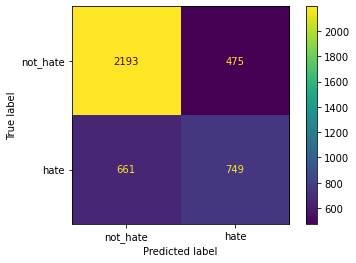

[0.82196402 0.53120567] [0.76839523 0.6119281 ] [0.79427744 0.56871678]
Validation accuracy: 0.7214320745463463

======== Epoch 2 / 4 ========
Training...
Total loss: 892.9483966976404


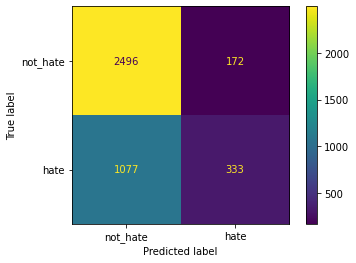

[0.93553223 0.23617021] [0.69857263 0.65940594] [0.79987182 0.34778068]
Validation accuracy: 0.6937224129475233

======== Epoch 3 / 4 ========
Training...
Total loss: 796.2561137378216


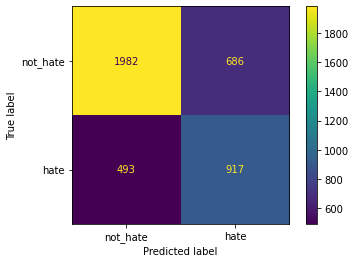

[0.74287856 0.65035461] [0.80080808 0.5720524 ] [0.77075637 0.60869565]
Validation accuracy: 0.7108876900441393

======== Epoch 4 / 4 ========
Training...
Total loss: 724.9229846894741


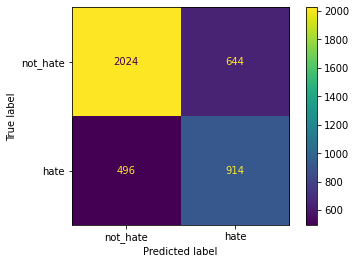

[0.75862069 0.64822695] [0.8031746  0.58664955] [0.78026214 0.61590296]
Validation accuracy: 0.7204512015693968

Training complete!


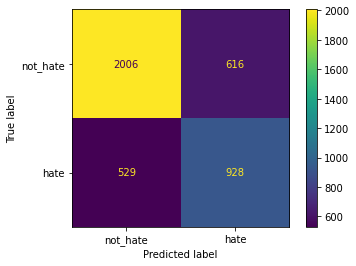

[0.76506484 0.63692519] [0.7913215  0.60103627] [0.77797169 0.61846051]
[0.76506484 0.63692519] [0.7913215  0.60103627] [0.77797169 0.61846051]
Test accuracy: 0.7192939445942633


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▆▄▆▃▄▄▁█▃▅▃▆▂█▄▅▄▄▅▄▂▃▄▆▄▅▄▅▃▂▄▂▂▃▂█▄▃▅▄
epoch,▁▁▁▁
loss,█▇▄▁
test_acc,▁
val_acc,█▁▅█
batch,1529
batch_loss,0.68774
best_lr,1e-05
best_randomseed,37
best_val,0.72143


wandb: Agent Starting Run: rbb2lpsc with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 910.8082076758146


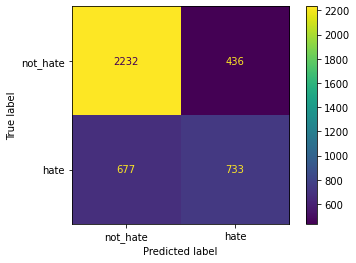

[0.83658171 0.51985816] [0.76727398 0.62703165] [0.80043034 0.56843738]
Validation accuracy: 0.7270720941638058

======== Epoch 2 / 4 ========
Training...
Total loss: 807.3796670809388


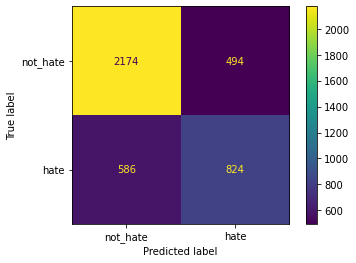

[0.81484258 0.58439716] [0.78768116 0.62518968] [0.80103169 0.60410557]
Validation accuracy: 0.735164296223639

======== Epoch 3 / 4 ========
Training...
Total loss: 714.2500552460551


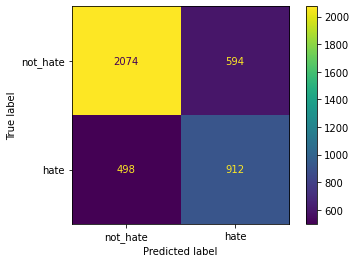

[0.77736132 0.64680851] [0.80637636 0.60557769] [0.79160305 0.6255144 ]
Validation accuracy: 0.7322216772927905

======== Epoch 4 / 4 ========
Training...
Total loss: 642.3922101184726


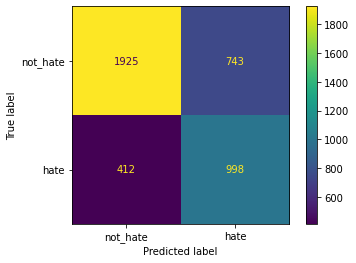

[0.72151424 0.70780142] [0.82370561 0.57323377] [0.76923077 0.6334497 ]
Validation accuracy: 0.7167729279058362

Training complete!


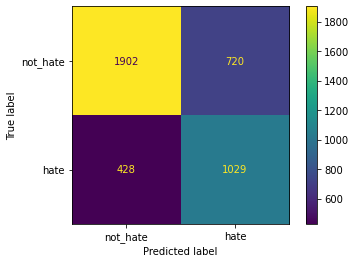

[0.72540046 0.70624571] [0.81630901 0.58833619] [0.76817447 0.6419214 ]
[0.72540046 0.70624571] [0.81630901 0.58833619] [0.76817447 0.6419214 ]
Test accuracy: 0.7185584702132876


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▆▄▆▄▄▃▃█▃▅▄▅▁█▄▄▄▄▄▃▃▂▄▇▄▂▄▇▄▂▄▃▂▃▂▇▃▁▅▄
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,▅█▇▁
batch,1529
batch_loss,0.60217
best_lr,1e-05
best_randomseed,69
best_val,0.73516


wandb: Agent Starting Run: 88aj1evp with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 906.4465164393187


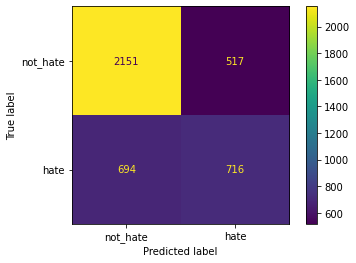

[0.80622189 0.50780142] [0.75606327 0.58069749] [0.78033738 0.54180855]
Validation accuracy: 0.7030407062285434

======== Epoch 2 / 4 ========
Training...
Total loss: 839.078113168478


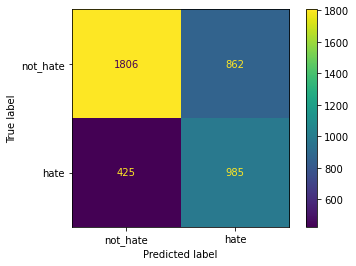

[0.67691154 0.69858156] [0.80950247 0.53329724] [0.73729333 0.60485109]
Validation accuracy: 0.6844041196665032

======== Epoch 3 / 4 ========
Training...
Total loss: 822.1660548299551


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


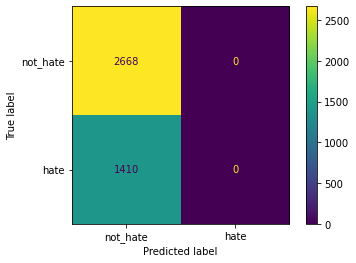

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 4 / 4 ========
Training...
Total loss: 994.515151143074


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


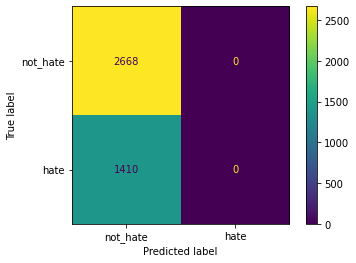

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


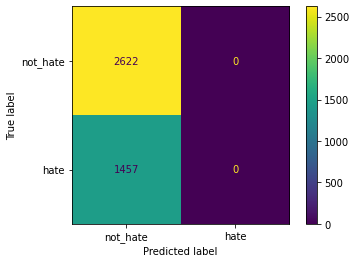

[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
Test accuracy: 0.6428046089727875


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▆▄▆▃▃▂▁▇▂▅▃▆▂▆▃▄▃▃▄▂▂▂▄▅▅▆▄█▅▄▇▃▇▄▄▅▅▆▄▇
epoch,▁▁▁▁
loss,▄▂▁█
test_acc,▁
val_acc,█▅▁▁
batch,1529
batch_loss,0.46956
best_lr,2e-05
best_randomseed,37
best_val,0.70304


wandb: Agent Starting Run: zdsibyjd with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 995.0686227679253


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


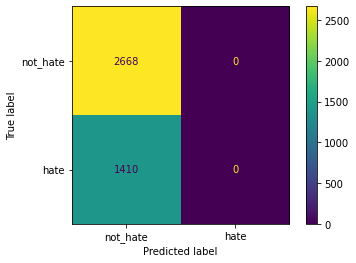

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 2 / 4 ========
Training...
Total loss: 991.9526781439781


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


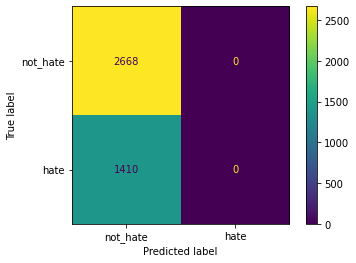

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 3 / 4 ========
Training...
Total loss: 991.0825271904469


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


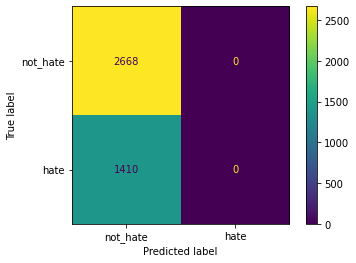

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 4 / 4 ========
Training...
Total loss: 990.1281819045544


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


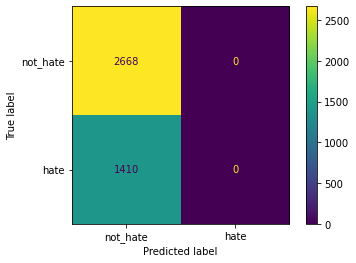

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


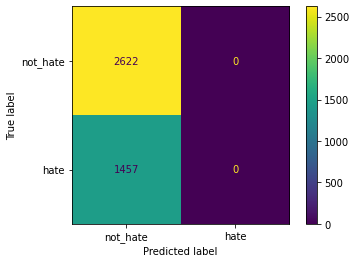

[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
Test accuracy: 0.6428046089727875


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▆▄▅▃▅▄▁▆▂▅▅▅▃▇▄▅▄▄▅▅▃▅▃▄▅▆▆█▅▄▅▃▇▄▄▄▄▆▄▇
epoch,▁▁▁▁
loss,█▄▂▁
test_acc,▁
val_acc,▁▁▁▁
batch,1529
batch_loss,0.48689
best_lr,2e-05
best_randomseed,69
best_val,0.65424


wandb: Agent Starting Run: dssm8j81 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 994.9905579090118


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


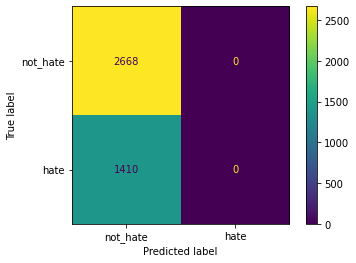

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 2 / 4 ========
Training...
Total loss: 958.9850255399942


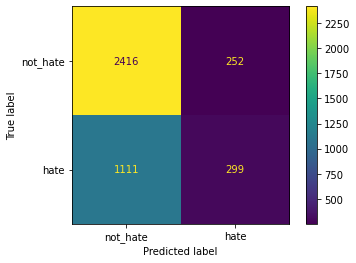

[0.90554723 0.21205674] [0.68500142 0.54264973] [0.77998386 0.30494646]
Validation accuracy: 0.665767533104463

======== Epoch 3 / 4 ========
Training...
Total loss: 965.0525054931641


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


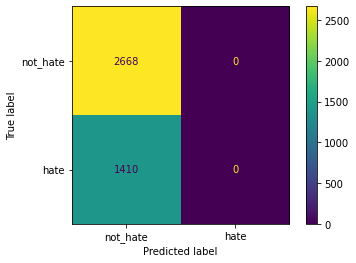

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 4 / 4 ========
Training...
Total loss: 992.6453784704208


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


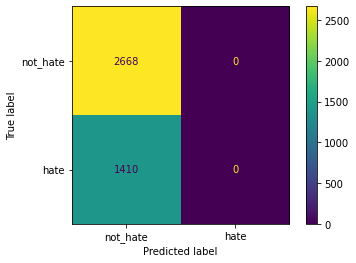

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


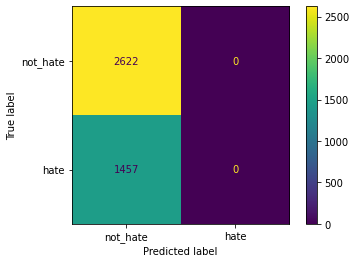

[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
Test accuracy: 0.6428046089727875


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▅▄▅▃▅▄▁▆▂▅▅▅▃▇▄▅▂▄▆▄▄▅▄▄▅▆▆█▅▄▆▃▇▄▄▅▅▆▄▇
epoch,▁▁▁▁
loss,█▁▂█
test_acc,▁
val_acc,▁█▁▁
batch,1529
batch_loss,0.48178
best_lr,3e-05
best_randomseed,37
best_val,0.66577


wandb: Agent Starting Run: 629uixrb with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 996.680075019598


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


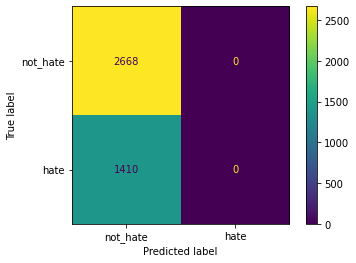

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 2 / 4 ========
Training...
Total loss: 993.702349036932


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


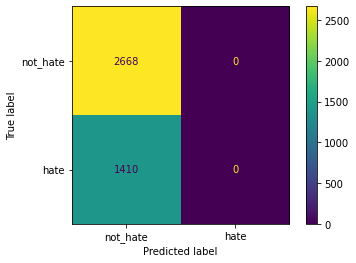

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 3 / 4 ========
Training...
Total loss: 992.6958065032959


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


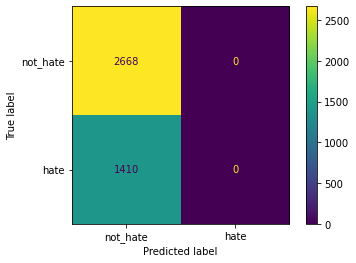

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

======== Epoch 4 / 4 ========
Training...
Total loss: 990.617067605257


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


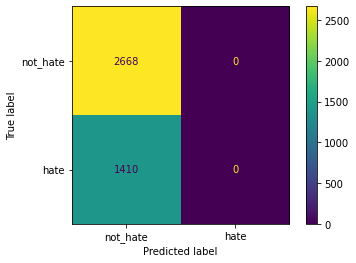

[1. 0.] [0.65424228 0.        ] [0.79098725 0.        ]
Validation accuracy: 0.6542422756253066

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


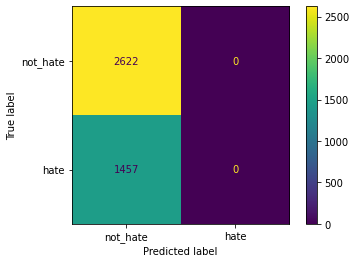

[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
[1. 0.] [0.64280461 0.        ] [0.78256977 0.        ]
Test accuracy: 0.6428046089727875


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▅▃▅▃▅▄▁▆▂▅▅▅▃▇▄▅▄▄▅▅▃▅▃▄▆▆▆█▅▄▅▃▇▄▄▄▅▆▄▇
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,▁▁▁▁
batch,1529
batch_loss,0.49313
best_lr,3e-05
best_randomseed,69
best_val,0.65424


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [29]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")